In [2]:
from ohlcv import ohlcvs
import asyncio
import nest_asyncio
import os
nest_asyncio.apply()
d=ohlcvs()
asyncio.run(d.run_kucoin_future('15m',1000))

get ohlcv


0

In [44]:
import pandas as pd
pairs = pd.read_pickle("data_pairs_kucoin_future_1m.pkl").loc[0,'pair']
pairs
# pairs['high'] + pairs['low'] + pairs['close'] * 2

,date,time,open,high,low,close,volume
0,09/07/2022,22:28:00,21854.0,21860.0,21854.0,21859.0,11241
1,09/07/2022,22:29:00,21859.0,21870.0,21859.0,21870.0,10290
2,09/07/2022,22:30:00,21870.0,21872.0,21869.0,21871.0,19090
3,09/07/2022,22:31:00,21872.0,21880.0,21871.0,21879.0,22978
4,09/07/2022,22:32:00,21879.0,21880.0,21877.0,21878.0,11509
...,...,...,...,...,...,...,...
995,10/07/2022,15:03:00,21301.0,21309.0,21301.0,21308.0,41665
996,10/07/2022,15:04:00,21309.0,21309.0,21306.0,21306.0,6261
997,10/07/2022,15:05:00,21307.0,21307.0,21295.0,21296.0,25530
998,10/07/2022,15:06:00,21296.0,21296.0,21295.0,21296.0,2368


C:\Users\hossain\AppData\Local\Programs\Python\Python37\lib\site-packages\mplfinance\_arg_validators.py:46: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


<IPython.core.display.Javascript object>


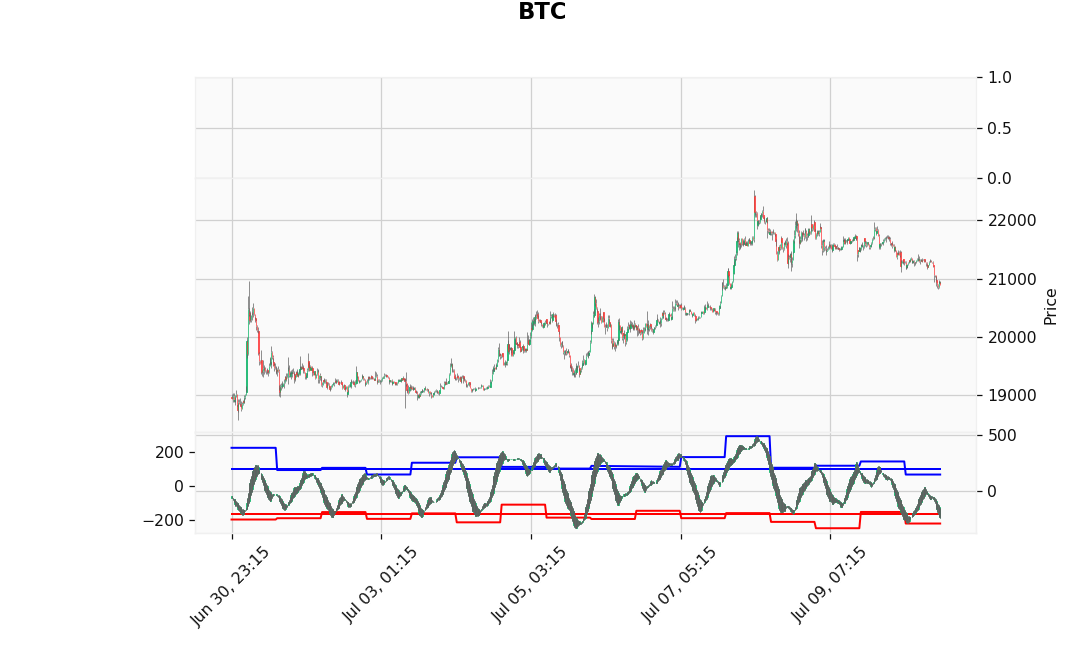

C:\Users\hossain\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\hossain\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\hossain\AppData\Local\Programs\Python\Python37\lib\site-packages\mplfinance\_arg_validators.py:46: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_

In [15]:
import pandas as pd
import talib as ta
import mplfinance as mpf
import numpy as np
%matplotlib notebook
df = pd.read_pickle("data_pairs_kucoin_future_15m.pkl").loc[0,'pair']
dff = pd.read_pickle("data_pairs_kucoin_future_15m.pkl").loc[0,'pair']

dff['date'] = dff['date'].astype(str) +' '+ dff['time'].astype(str)
dff['date']= pd.to_datetime(dff['date'], format='%d/%m/%Y %H:%M:%S')
dff.set_index('date', inplace=True)
dff.drop('time', axis=1,inplace=True)

Smoother=14
nn = Smoother
SupResPeriod = 60
SupResPercentage =100
overbought = 200
overssold = -200

ys1 = ( df['high'] + df['low'] + df['close'] * 2 ) / 4
rk3 =ta.EMA(ys1, timeperiod=nn)
rk4 = ta.STDDEV(ys1, timeperiod=nn)
rk5 = ((ys1 - rk3 ) * 200) / rk4
rk6 = ta.EMA(rk5, timeperiod=nn)
up = ta.EMA(rk6, timeperiod=nn) 
down = ta.EMA(up, timeperiod=nn)
up = pd.DataFrame(up)
down = pd.DataFrame(down)
Hh=pd.DataFrame(0,columns=up.columns,index=up.index)
Ll=pd.DataFrame(0,columns=up.columns,index=up.index)
for i in up.index:
    if (up.loc[i]<down.loc[i]).bool():
        Hh.at[i] = up.loc[i]
    else:
        Hh.at[i] = down.loc[i]

for i in up.index:
    if (up.loc[i]<down.loc[i]).bool():
        Ll.at[i] = down.loc[i]
    else:
        Ll.at[i] = up.loc[i]
df['open']=Hh.copy()
df['high']=Hh.copy()
df['low']=Ll.copy()
df['close']=Ll.copy()
df['MCOverrides'] = up>down #set for color
df['date'] = df['date'].astype(str) +' '+ df['time'].astype(str)
df['date']= pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M:%S')
df.set_index('date', inplace=True)
df.drop('time', axis=1,inplace=True)


for ts in df[df['MCOverrides']==True].index:
    df.loc[ts,'MCOverrides'] = 'green'
for ts in df[df['MCOverrides']==False].index:
    df.loc[ts,'MCOverrides'] = 'red'


df=df.dropna()
mco = df['MCOverrides'].values


from AlmaIndicator.Alma import *
def cci(data,nro=21):
    alma_indicator = ALMAIndicator(close=data,window=nro)
    alma= alma_indicator.alma()
    ci = (data - alma) / (0.015 * ta.STDDEV(data, timeperiod=nro, nbdev=1))
    return ci


Lookback = SupResPeriod
PerCent = SupResPercentage
Pds = 16.5
# C3=cci(dff['close'],nro=Pds)
C3=ta.CCI(dff['high'],dff['low'] ,dff['close'] , timeperiod=Pds)
C3 = pd.DataFrame(C3)
C3 =C3[len(dff)-len(df):] #set row need
dff=dff[len(dff)-len(df):]
Osc = C3
Value1 = Osc
i=0
Value2=[]
while i< len(C3):
    if i+Lookback>len(C3):
        Value2.append(C3.iloc[i:len(C3),0].max())
        break
    Value2.append(C3.iloc[i:i+Lookback,0].max())
    i+=Lookback

i=0
Value3=[]
while i< len(C3):
    if i+Lookback>len(C3):
        Value3.append(C3.iloc[i:len(C3),0].min())
        break
    Value3.append(C3.iloc[i:i+Lookback,0].min())
    i+=Lookback
Value4 =[element1 - element2 for (element1, element2) in zip(Value2, Value3)]

Value5 = [i * (PerCent / 100 ) for i in Value4]
ResistanceLine = [element1 - element2 for (element1, element2) in zip(Value3, Value5)]
SupportLine = [element1 - element2 for (element1, element2) in zip(Value2, Value5)]
df['ResistanceLine']=0
df['SupportLine']=0
i=0
j=0
while i< len(C3):
    if (i+Lookback)>len(C3):
        df.iloc[i:len(C3),-2]=Value2[j]
        break
    df.iloc[i:i+Lookback,-2]=Value2[j]
    i+=Lookback
    j+=1

i=0
j=0
while i< len(C3):

    if (i+Lookback)>len(C3):
        df.iloc[i:len(C3),-1]=Value3[j]
        break
    df.iloc[i:i+Lookback,-1]=Value3[j]
    i+=Lookback
    j+=1
df['uperbond']=200
df['bottombond']=-200
apd = [mpf.make_addplot(df['ResistanceLine'],color='blue',panel=2),mpf.make_addplot(df['SupportLine'],color='red',panel=2),
       mpf.make_addplot(df.iloc[:,0:4], type='candle',panel=2),
      mpf.make_addplot(df['uperbond'], type='line',panel=2,color='blue'),
       mpf.make_addplot(df['bottombond'], type='line',panel=2,color='red')]
#        mpf.make_addplot(sell,type='scatter',markersize=40,marker='v',color='black'),
# mpf.make_addplot(buy,type='scatter',markersize=40,marker='^',color='orange')]
mpf.plot(dff,addplot=apd, type='candle',style='yahoo', figratio=(30,18), title='BTC',main_panel=1)
# mpf.plot(df.iloc[:,0:4], type='candle',style='yahoo',marketcolor_overrides=mco,hlines=[-200,200])

# 
# plot(dynamic?ResistanceLine:na,color=green,transp=0)
# plot(dynamic?SupportLine:na,color=red,transp=0)

# //--Overbought/Oversold/Warning Detail
# UPshape = up > ob and up>down ? highest(up,1) + 20:up > ob and up<down?highest(down,1) + 20:na
# DOWNshape = down < os and up>down ? lowest(down,1) - 20:down < os and up<down?lowest(up,1) - 20 :na
# plot(UPshape,style=cross,color=aqua,linewidth=2,transp=0)
# plot(DOWNshape,style=cross,color=aqua,linewidth=2,transp=0)
# x1=OBOS?ob:false
# x2=OBOS?os:false
# hline(x1)
# hline(x2)